In [1]:
import numpy as np               
import pandas as pd 
import nltk
import string
import re

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier 

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold 

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc, roc_auc_score

#nltk.download()
#nltk.download('punkt')

In [2]:
reviews = pd.read_csv('yelp_labelled.csv')
reviews = reviews.astype({'Text':'string'})
text = reviews['Text']
text1 = []
for review in text:
    #print(sentence)
    #remove punctuation
    review = review.translate(str.maketrans('', '', string.punctuation))  
    # remove digits/numbers
    review = review.translate(str.maketrans('', '', string.digits))
    #change to lowercase
    review = review.lower()
    #print(sentence)
    text1.append(review)
text1 = pd.Series(text1)
stop_words = set(stopwords.words('english'))

text1 = text1.apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))
def get_wordnet_pos(word):

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


lemmatizer = WordNetLemmatizer()
text3 = text1.apply(lambda x:' '.join(lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in x.split()))
label = reviews['Sentiment']
reviews1 = list(zip(text3, label))

reviewsP = pd.DataFrame (reviews1, columns = ['Review', 'Sentiment'])
reviewsP.head()

,Review,Sentiment
0,wow love place,1
1,crust good,0
2,tasty texture nasty,0
3,stop late may bank holiday rick steve recommen...,1
4,selection menu great price,1


In [3]:
y1 = reviewsP['Sentiment']

In [4]:
y1.shape

(1000,)

In [5]:
cv=CountVectorizer()
cv_reviews = cv.fit_transform(reviewsP['Review'])

tv=TfidfVectorizer()
tv_reviews=tv.fit_transform(reviewsP['Review'])

In [6]:
cv_reviews.shape

(1000, 1675)

In [7]:
cv_reviews

<1000x1675 sparse matrix of type '<class 'numpy.int64'>'
	with 5488 stored elements in Compressed Sparse Row format>

In [8]:
print(cv_reviews)

  (0, 1654)	1
  (0, 855)	1
  (0, 1095)	1
  (1, 342)	1
  (1, 625)	1
  (2, 1459)	1
  (2, 1471)	1
  (2, 962)	1
  (3, 855)	1
  (3, 1404)	1
  (3, 813)	1
  (3, 891)	1
  (3, 99)	1
  (3, 704)	1
  (3, 1232)	1
  (3, 1397)	1
  (3, 1196)	1
  (4, 1290)	1
  (4, 912)	1
  (4, 637)	1
  (4, 1132)	1
  (5, 611)	1
  (5, 36)	1
  (5, 1599)	1
  (5, 353)	1
  :	:
  (997, 90)	1
  (997, 1024)	1
  (997, 747)	1
  (998, 1495)	1
  (998, 620)	1
  (998, 1482)	1
  (998, 1620)	1
  (998, 503)	1
  (998, 1545)	1
  (998, 973)	1
  (998, 1443)	1
  (998, 1627)	1
  (998, 977)	1
  (999, 1495)	1
  (999, 1449)	1
  (999, 476)	1
  (999, 1261)	1
  (999, 1605)	1
  (999, 241)	1
  (999, 833)	1
  (999, 174)	1
  (999, 656)	1
  (999, 1123)	1
  (999, 1653)	1
  (999, 434)	1


In [9]:
def plot_roc_auc(y, y_pred):
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    if title:
        plt.title(title)
    plt.show()

In [10]:
def multiclass_cv_decision_tree(X, y, cv=5, scoring='f1_macro', max_depth=None, random_state=12):
    clf = DecisionTreeClassifier(max_depth=max_depth, criterion='entropy')

    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    scores = cross_val_score(clf, X, y, cv=cv_strategy, scoring=scoring)
    
    y_pred = cross_val_predict(clf, X, y, cv=cv_strategy)

    accuracy = accuracy_score(y, y_pred)
    classification_rep = classification_report(y, y_pred)
    f1 = f1_score(y, y_pred, average='macro')
    AUC_score = roc_auc_score(y, y_pred)
    plot_roc_auc(y, y_pred)
    plot_confusion_matrix(y, y_pred, classes=sorted(y.unique().tolist()), title='Confusion Matrix')
    print("Decision Tree - Cross-Validation AUC_score:", AUC_score)
    print("Decision Tree - Cross-Validation Accuracy:", accuracy)
    print("Decision Tree - Cross-Validation Classification Report:\n", classification_rep)
    print("Decision Tree - Cross-Validation F1 Scores:", scores)
    print("Decision Tree - Cross-Validation Average F1 Score with variance:", (scores.mean(), scores.std() **2))
    return scores, accuracy, AUC_score

In [11]:
def multiclass_cv_logistic_regression(X, y, cv=10, scoring='f1_macro', random_state=12, solver='lbfgs', max_iter=100):

    clf = LogisticRegression(solver=solver, max_iter=max_iter, random_state=random_state)
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    scores = cross_val_score(clf, X, y, cv=cv_strategy, scoring=scoring)

    y_pred = cross_val_predict(clf, X, y, cv=cv_strategy)

    accuracy = accuracy_score(y, y_pred)
    classification_rep = classification_report(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    AUC_score = roc_auc_score(y, y_pred)
    plot_roc_auc(y, y_pred)
    plot_confusion_matrix(y, y_pred, classes=sorted(y.unique().tolist()), title='Confusion Matrix')
    print("Logistic - Cross-Validation AUC_score:", AUC_score)
    print("Logistic - Cross-Validation Accuracy:", accuracy)
    print("Logistic - Cross-Validation Classification Report:\n", classification_rep)
    print("Logistic - Cross-Validation F1 Scores:", scores)
    print("Logistic - Cross-Validation Average F1 Score with variance:", (scores.mean(), scores.std() **2))
    return scores, accuracy, AUC_score

In [12]:
def multiclass_cv_svm(X, y, cv=10, scoring='f1_macro', random_state=12, kernel='rbf', C=1.0, gamma='scale'):

    clf = SVC(kernel=kernel, C=C, gamma=gamma, random_state=random_state)
    
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
    scores = cross_val_score(clf, X, y, cv=cv_strategy, scoring=scoring)

    
    y_pred = cross_val_predict(clf, X, y, cv=cv_strategy)

    accuracy = accuracy_score(y, y_pred)
    classification_rep = classification_report(y, y_pred)

    AUC_score = roc_auc_score(y, y_pred)
    plot_roc_auc(y, y_pred)
    plot_confusion_matrix(y, y_pred, classes=sorted(y.unique().tolist()), title='Confusion Matrix')
    print("SVM - Cross-Validation AUC_score:", AUC_score)
    print("SVM - Cross-Validation Accuracy:", accuracy)
    print("SVM - Cross-Validation Classification Report:\n", classification_rep)
    print("SVM - Cross-Validation F1 Scores:", scores)
    print("SVM - Cross-Validation Average F1 Score with variance:", (scores.mean(), scores.std() **2))
    return scores, accuracy, AUC_score

C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\A

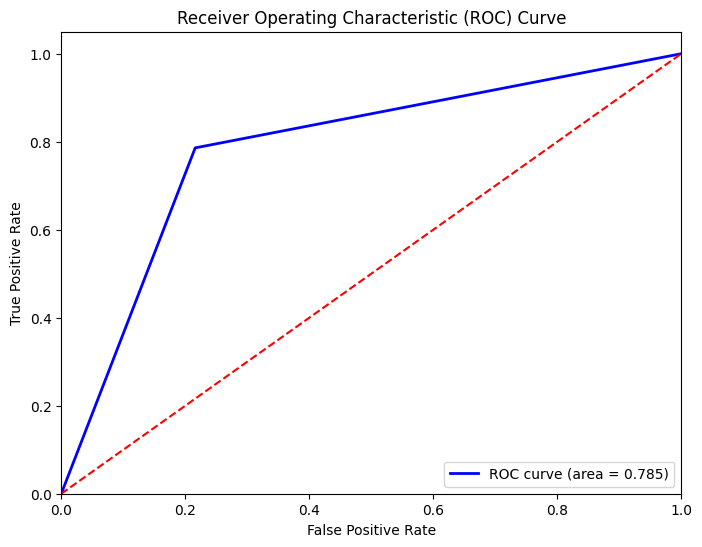

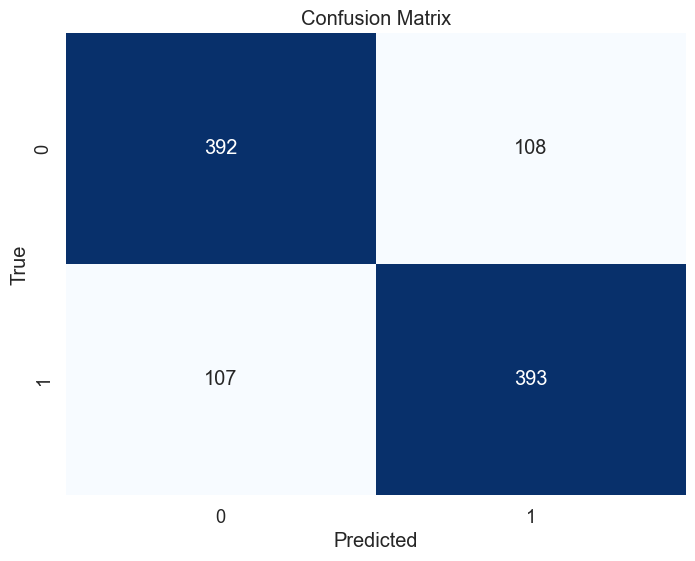

MLP - Cross-Validation AUC_score: 0.785
MLP - Accuracy: 0.785
MLP - Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       500
           1       0.78      0.79      0.79       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.78      1000
weighted avg       0.79      0.79      0.78      1000

MLP - Cross-Validation F1 Scores: [0.83942192 0.809981   0.79991997 0.729973   0.809981   0.77964744
 0.729973   0.78896593 0.749975   0.809981  ]
MLP - Cross-Validation Average F1 Score with variance: (0.7847819242263394, 0.001238309735023056)


(array([0.83942192, 0.809981  , 0.79991997, 0.729973  , 0.809981  ,
        0.77964744, 0.729973  , 0.78896593, 0.749975  , 0.809981  ]),
 0.785,
 0.785)

In [13]:
def multiclass_cv_mlp(X, y, cv=10, scoring='f1_macro', hidden_layer_sizes=(100,), max_iter=100, random_state=12):
 

    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=random_state)
    
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=12)
    scores = cross_val_score(clf, X, y, cv=cv_strategy, scoring=scoring)

    y_pred = cross_val_predict(clf, X, y, cv=cv_strategy)

    accuracy = accuracy_score(y, y_pred)
    classification_rep = classification_report(y, y_pred)

    AUC_score = roc_auc_score(y, y_pred)
    plot_roc_auc(y, y_pred)
    plot_confusion_matrix(y, y_pred, classes=sorted(y.unique().tolist()), title='Confusion Matrix')
    print("MLP - Cross-Validation AUC_score:", AUC_score)
    print(f"MLP - Accuracy: {accuracy}")
    print("MLP - Classification Report:")
    print(classification_rep)
    print("MLP - Cross-Validation F1 Scores:", scores)
    print("MLP - Cross-Validation Average F1 Score with variance:", (scores.mean(), scores.std() **2))
    return scores, accuracy, AUC_score

C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\A

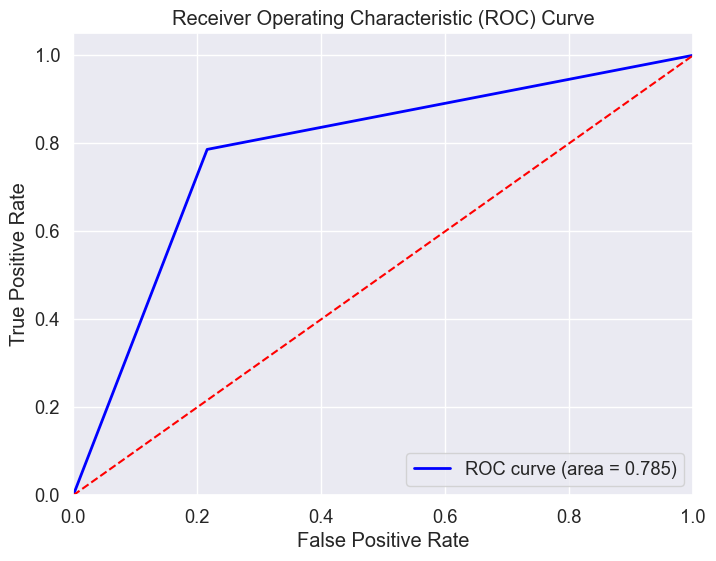

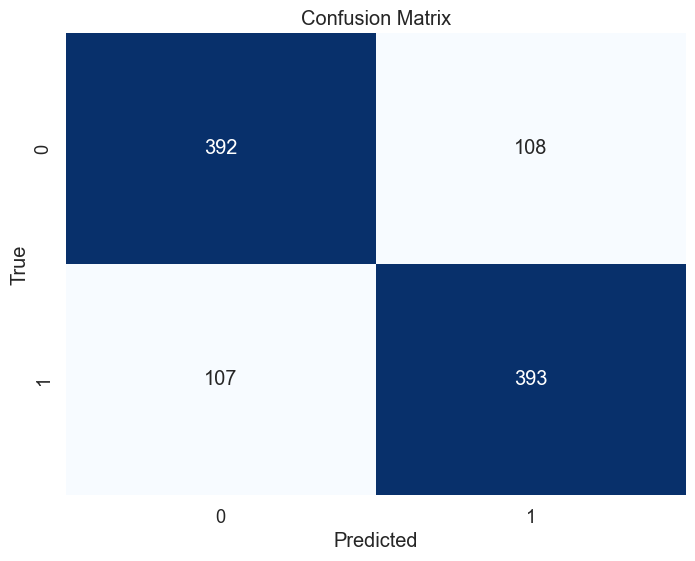

MLP - Cross-Validation AUC_score: 0.785
MLP - Accuracy: 0.785
MLP - Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       500
           1       0.78      0.79      0.79       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.78      1000
weighted avg       0.79      0.79      0.78      1000

MLP - Cross-Validation F1 Scores: [0.83942192 0.809981   0.79991997 0.729973   0.809981   0.77964744
 0.729973   0.78896593 0.749975   0.809981  ]
MLP - Cross-Validation Average F1 Score with variance: (0.7847819242263394, 0.001238309735023056)


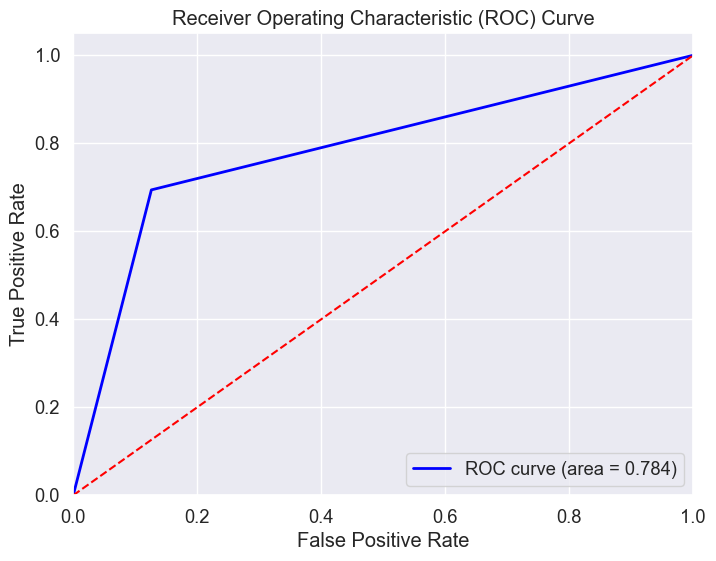

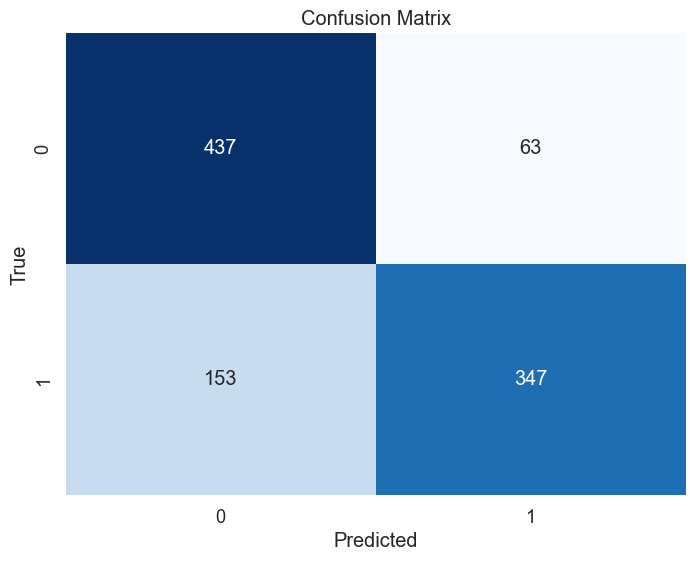

SVM - Cross-Validation AUC_score: 0.784
SVM - Cross-Validation Accuracy: 0.784
SVM - Cross-Validation Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.87      0.80       500
           1       0.85      0.69      0.76       500

    accuracy                           0.78      1000
   macro avg       0.79      0.78      0.78      1000
weighted avg       0.79      0.78      0.78      1000

SVM - Cross-Validation F1 Scores: [0.72535856 0.81934966 0.7756018  0.73737374 0.71590909 0.83993597
 0.8067338  0.8291629  0.77920514 0.78896593]
SVM - Cross-Validation Average F1 Score with variance: (0.781759658730083, 0.0017252133233811647)


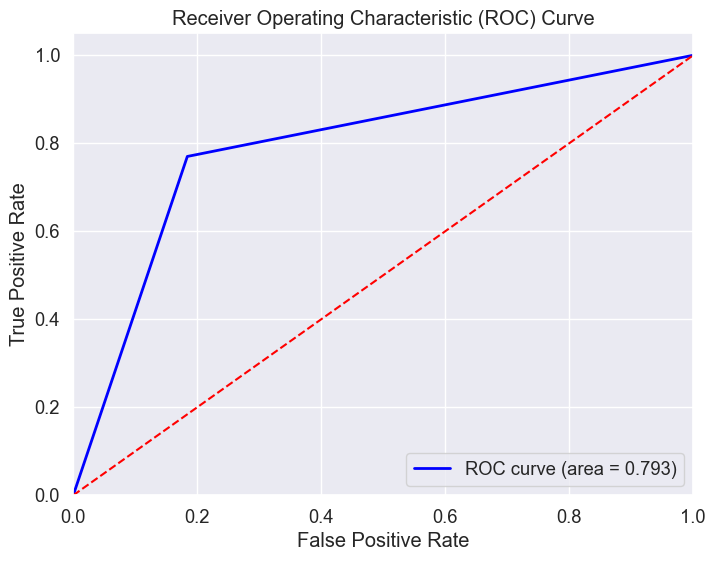

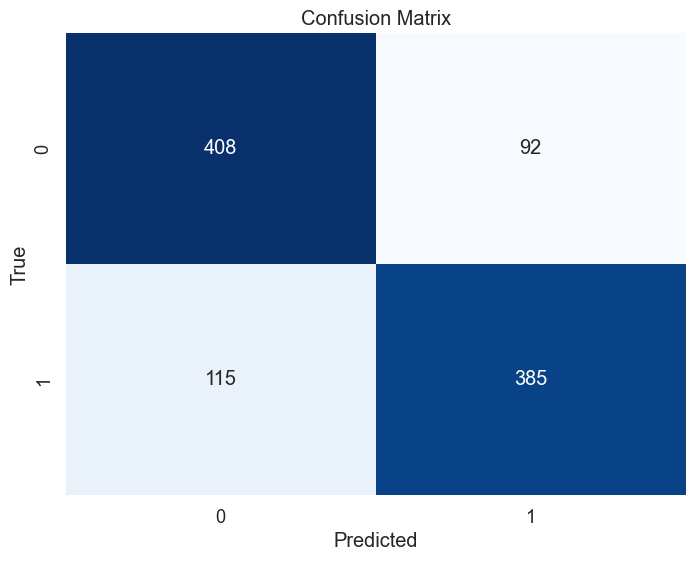

Logistic - Cross-Validation AUC_score: 0.793
Logistic - Cross-Validation Accuracy: 0.793
Logistic - Cross-Validation Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80       500
           1       0.81      0.77      0.79       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000

Logistic - Cross-Validation F1 Scores: [0.82861176 0.79991997 0.78981083 0.789979   0.829983   0.77964744
 0.78947368 0.78947368 0.74937343 0.77991196]
Logistic - Cross-Validation Average F1 Score with variance: (0.7926184751839209, 0.0004979401615809333)


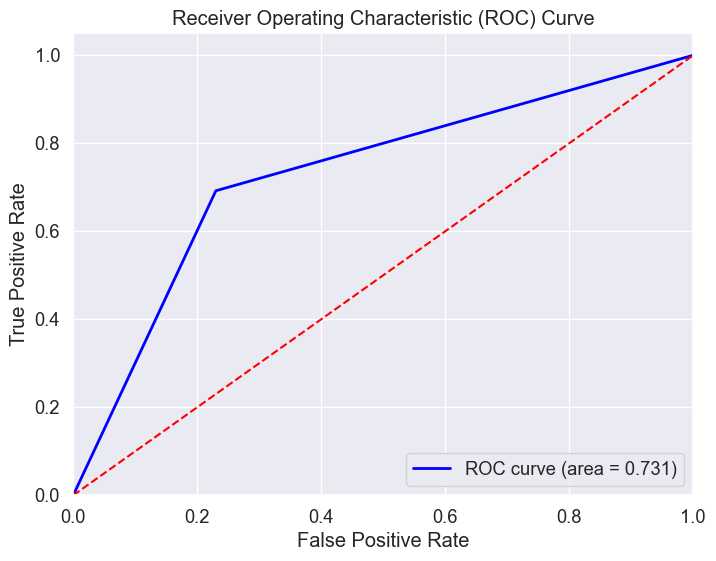

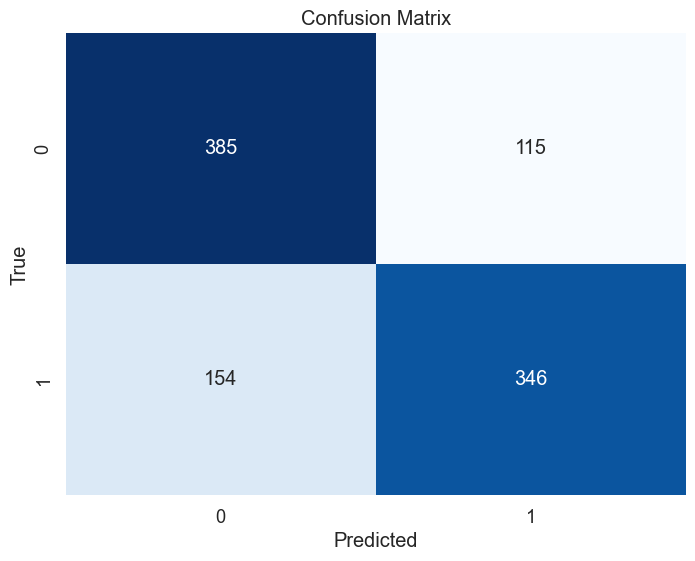

Decision Tree - Cross-Validation AUC_score: 0.731
Decision Tree - Cross-Validation Accuracy: 0.731
Decision Tree - Cross-Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.77      0.74       500
           1       0.75      0.69      0.72       500

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000

Decision Tree - Cross-Validation F1 Scores: [0.73446229 0.74468724 0.73976579 0.73419594 0.70171137]
Decision Tree - Cross-Validation Average F1 Score with variance: (0.7309645255536144, 0.00022883976157311807)


C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\A

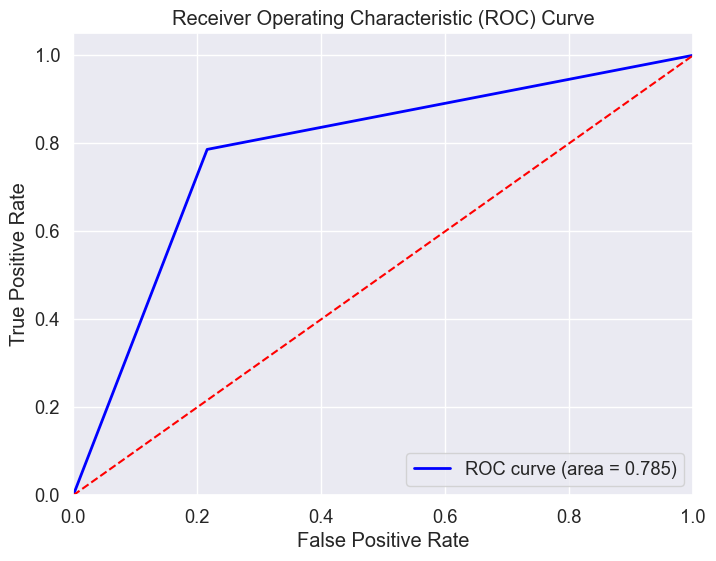

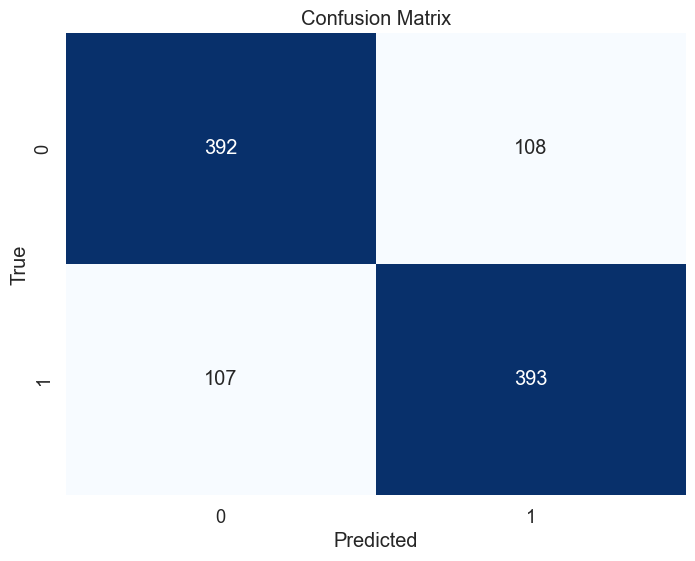

MLP - Cross-Validation AUC_score: 0.785
MLP - Accuracy: 0.785
MLP - Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       500
           1       0.78      0.79      0.79       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.78      1000
weighted avg       0.79      0.79      0.78      1000

MLP - Cross-Validation F1 Scores: [0.83942192 0.809981   0.79991997 0.729973   0.809981   0.77964744
 0.729973   0.78896593 0.749975   0.809981  ]
MLP - Cross-Validation Average F1 Score with variance: (0.7847819242263394, 0.001238309735023056)


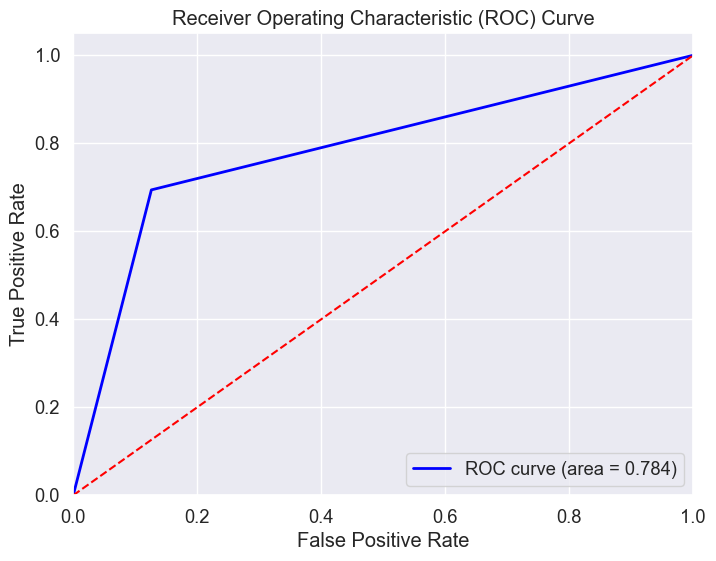

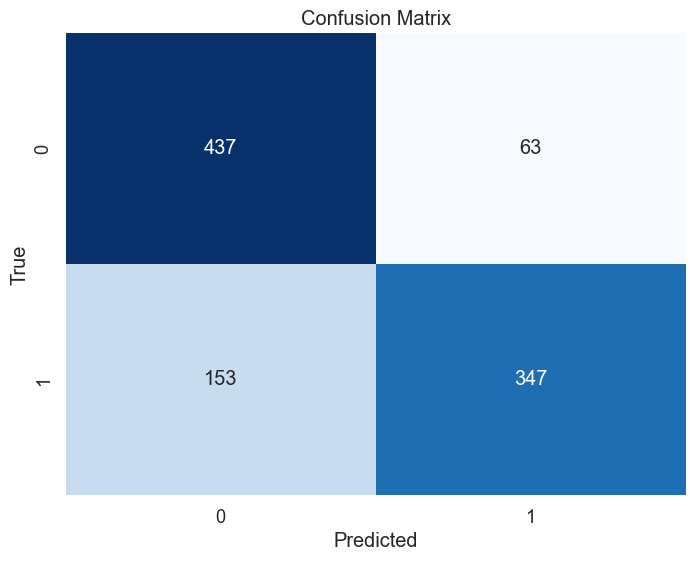

SVM - Cross-Validation AUC_score: 0.784
SVM - Cross-Validation Accuracy: 0.784
SVM - Cross-Validation Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.87      0.80       500
           1       0.85      0.69      0.76       500

    accuracy                           0.78      1000
   macro avg       0.79      0.78      0.78      1000
weighted avg       0.79      0.78      0.78      1000

SVM - Cross-Validation F1 Scores: [0.72535856 0.81934966 0.7756018  0.73737374 0.71590909 0.83993597
 0.8067338  0.8291629  0.77920514 0.78896593]
SVM - Cross-Validation Average F1 Score with variance: (0.781759658730083, 0.0017252133233811647)


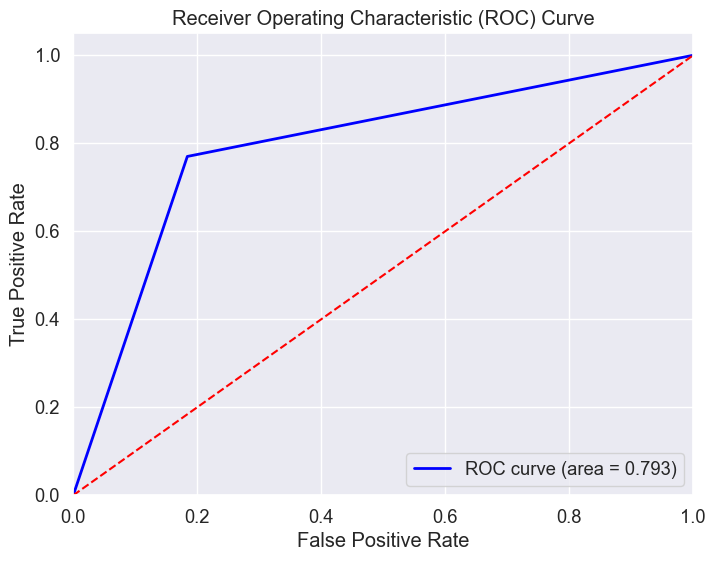

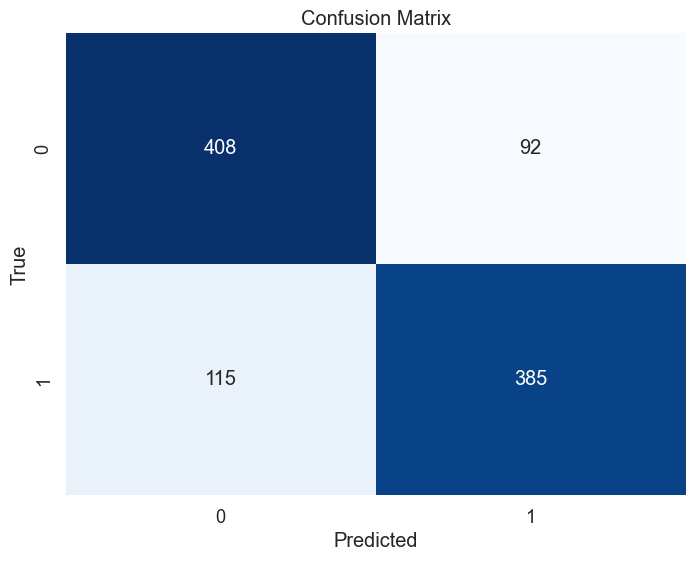

Logistic - Cross-Validation AUC_score: 0.793
Logistic - Cross-Validation Accuracy: 0.793
Logistic - Cross-Validation Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80       500
           1       0.81      0.77      0.79       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000

Logistic - Cross-Validation F1 Scores: [0.82861176 0.79991997 0.78981083 0.789979   0.829983   0.77964744
 0.78947368 0.78947368 0.74937343 0.77991196]
Logistic - Cross-Validation Average F1 Score with variance: (0.7926184751839209, 0.0004979401615809333)


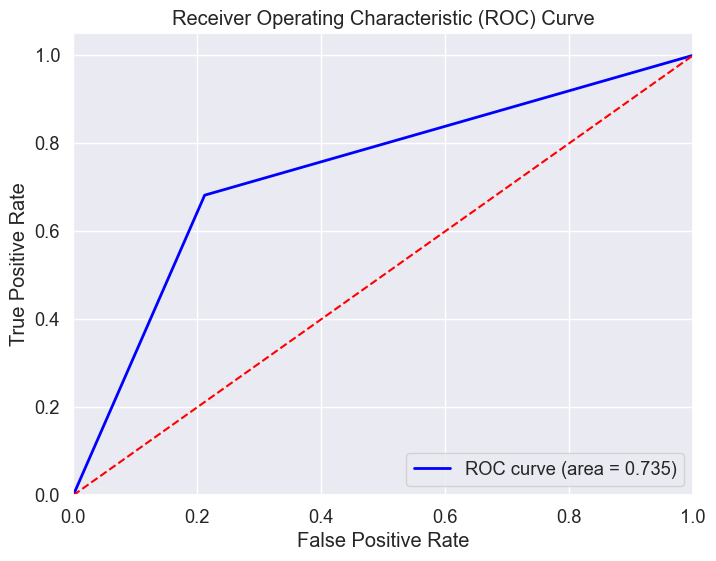

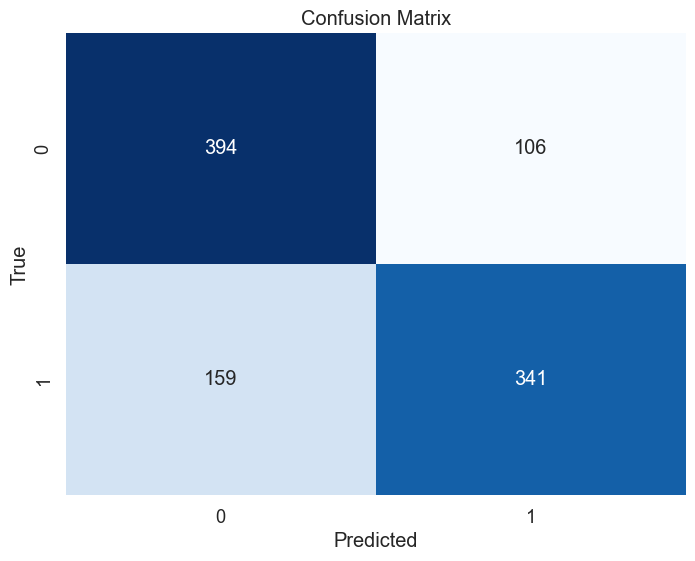

Decision Tree - Cross-Validation AUC_score: 0.735
Decision Tree - Cross-Validation Accuracy: 0.735
Decision Tree - Cross-Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.79      0.75       500
           1       0.76      0.68      0.72       500

    accuracy                           0.73      1000
   macro avg       0.74      0.74      0.73      1000
weighted avg       0.74      0.73      0.73      1000

Decision Tree - Cross-Validation F1 Scores: [0.71898836 0.73499337 0.73989596 0.72299867 0.71240445]
Decision Tree - Cross-Validation Average F1 Score with variance: (0.7258561613653539, 0.00010337702196834722)


C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\A

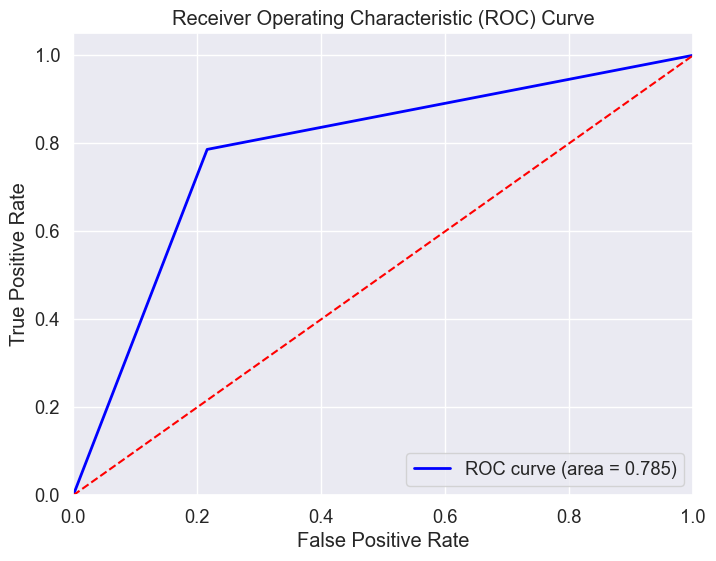

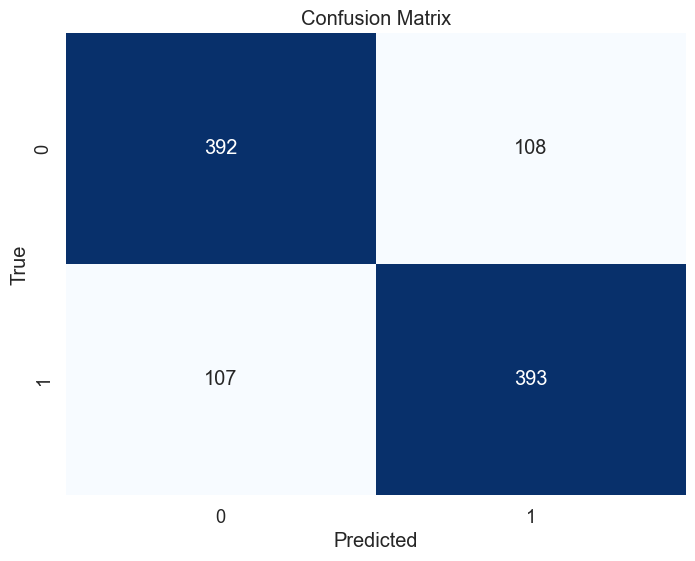

MLP - Cross-Validation AUC_score: 0.785
MLP - Accuracy: 0.785
MLP - Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       500
           1       0.78      0.79      0.79       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.78      1000
weighted avg       0.79      0.79      0.78      1000

MLP - Cross-Validation F1 Scores: [0.83942192 0.809981   0.79991997 0.729973   0.809981   0.77964744
 0.729973   0.78896593 0.749975   0.809981  ]
MLP - Cross-Validation Average F1 Score with variance: (0.7847819242263394, 0.001238309735023056)


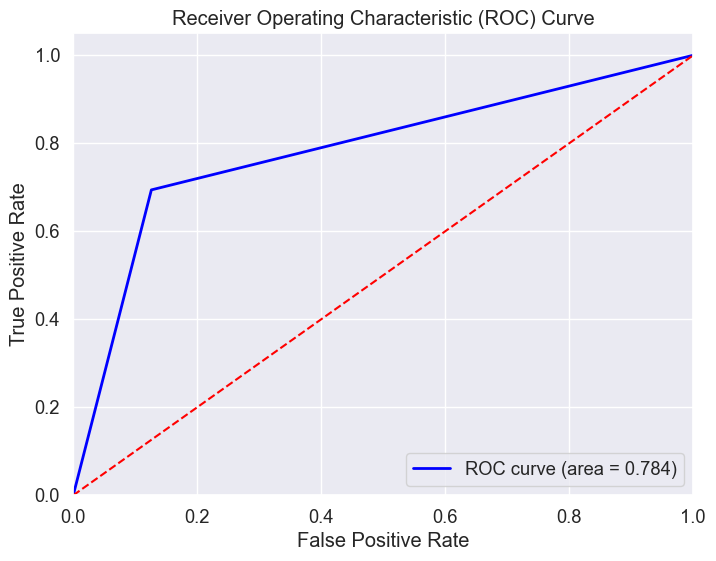

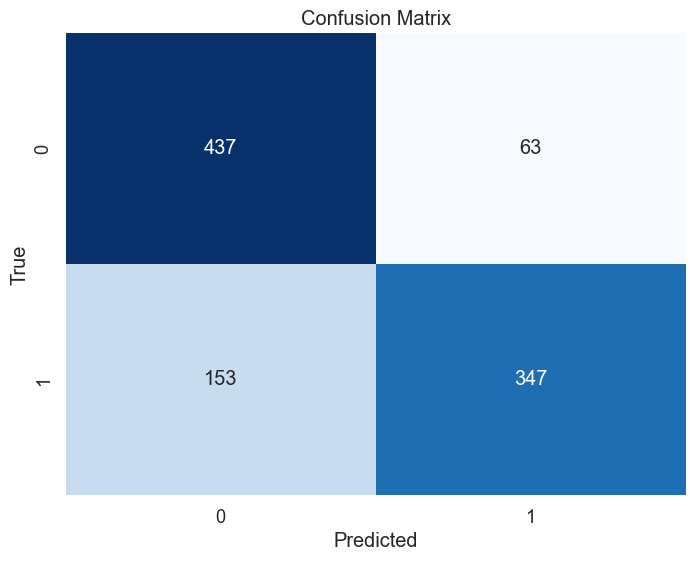

SVM - Cross-Validation AUC_score: 0.784
SVM - Cross-Validation Accuracy: 0.784
SVM - Cross-Validation Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.87      0.80       500
           1       0.85      0.69      0.76       500

    accuracy                           0.78      1000
   macro avg       0.79      0.78      0.78      1000
weighted avg       0.79      0.78      0.78      1000

SVM - Cross-Validation F1 Scores: [0.72535856 0.81934966 0.7756018  0.73737374 0.71590909 0.83993597
 0.8067338  0.8291629  0.77920514 0.78896593]
SVM - Cross-Validation Average F1 Score with variance: (0.781759658730083, 0.0017252133233811647)


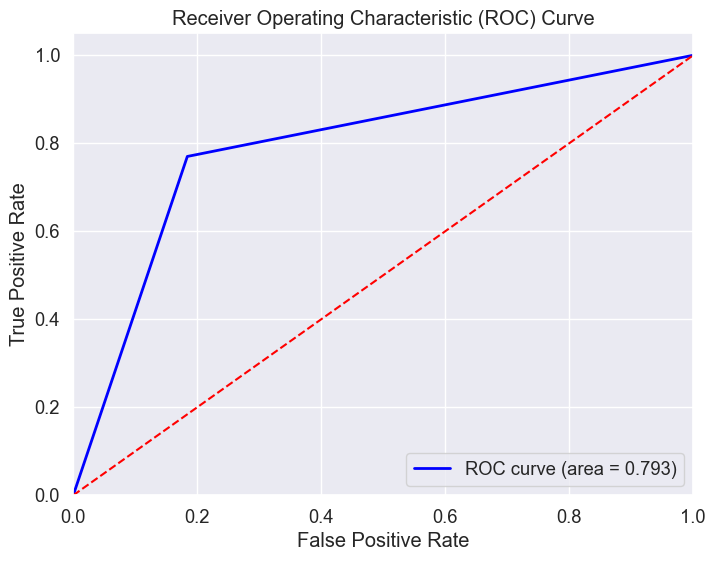

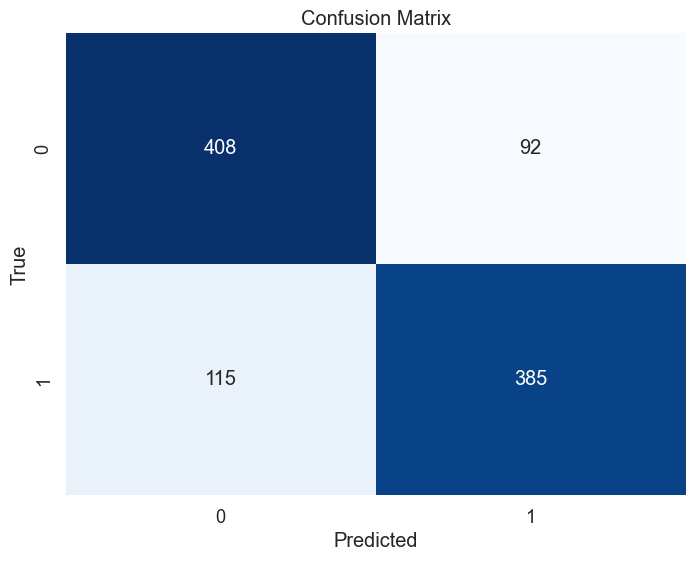

Logistic - Cross-Validation AUC_score: 0.793
Logistic - Cross-Validation Accuracy: 0.793
Logistic - Cross-Validation Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80       500
           1       0.81      0.77      0.79       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000

Logistic - Cross-Validation F1 Scores: [0.82861176 0.79991997 0.78981083 0.789979   0.829983   0.77964744
 0.78947368 0.78947368 0.74937343 0.77991196]
Logistic - Cross-Validation Average F1 Score with variance: (0.7926184751839209, 0.0004979401615809333)


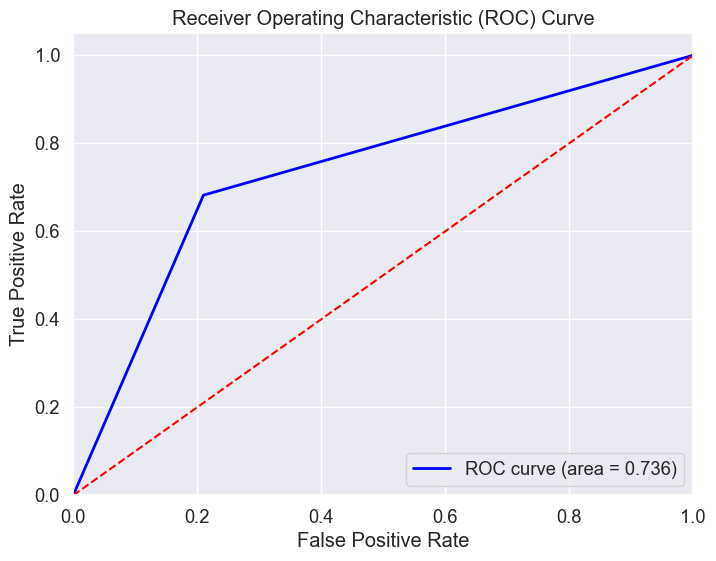

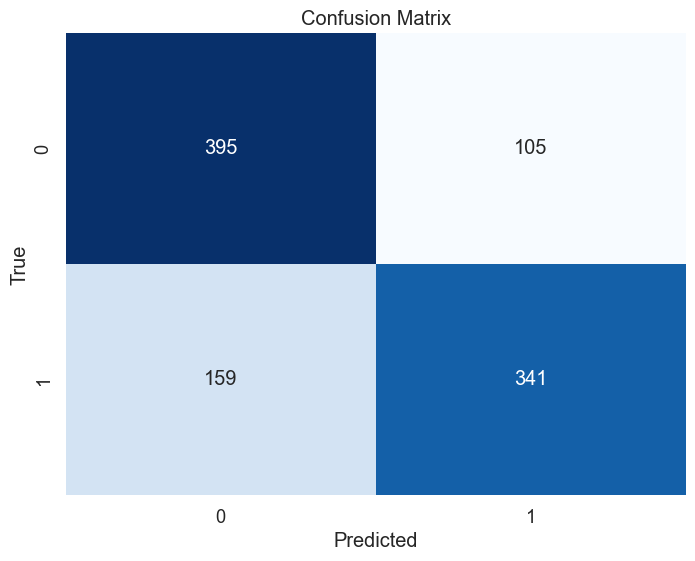

Decision Tree - Cross-Validation AUC_score: 0.736
Decision Tree - Cross-Validation Accuracy: 0.736
Decision Tree - Cross-Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.79      0.75       500
           1       0.76      0.68      0.72       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000

Decision Tree - Cross-Validation F1 Scores: [0.71379077 0.72499312 0.73906062 0.73307144 0.71771348]
Decision Tree - Cross-Validation Average F1 Score with variance: (0.7257258858767586, 8.779099117529758e-05)


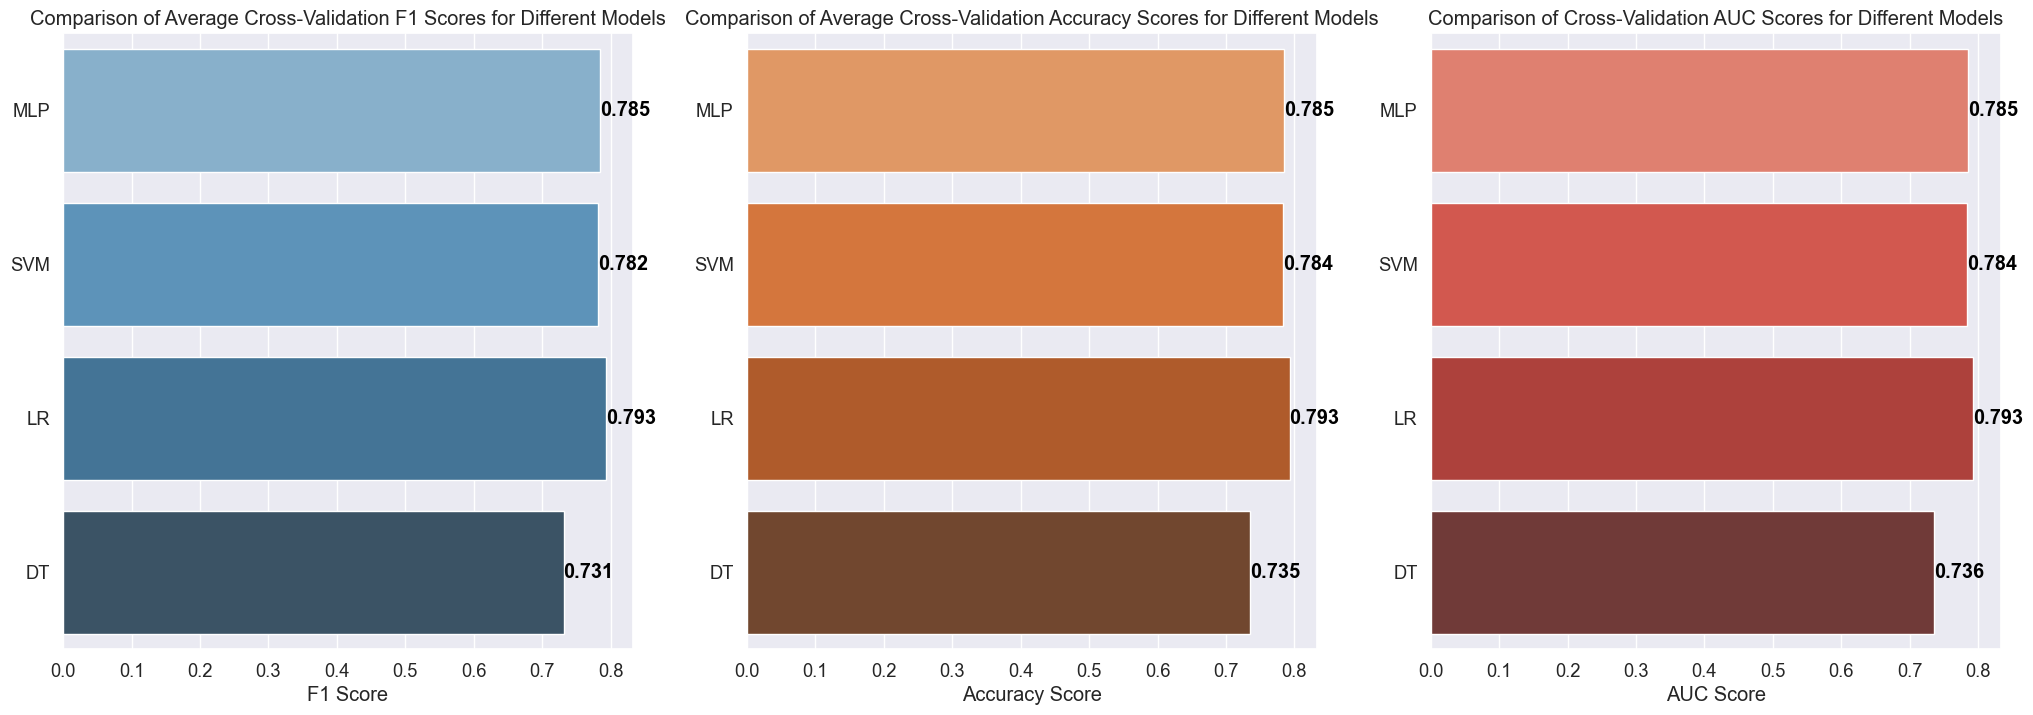

In [22]:
auc_scores = []
a_scores = []
f1_scores = []

functions = [multiclass_cv_mlp, multiclass_cv_svm, multiclass_cv_logistic_regression, multiclass_cv_decision_tree]
labels = ["MLP", "SVM", "LR", "DT"]

for func in functions:
    f1 = func(cv_reviews, y1)[0].mean()
    f1_scores.append(f1)
for func in functions:
    a = func(cv_reviews, y1)[1]
    a_scores.append(a)
for func in functions:
    au = func(cv_reviews, y1)[2]
    auc_scores.append(au)

# Combine all three plots into one figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(25, 8))

# F1 Score subplot
sns.barplot(ax=axes[0], x=f1_scores, y=labels, palette="Blues_d")
axes[0].set_xlabel('F1 Score')
axes[0].set_title('Comparison of Average Cross-Validation F1 Scores for Different Models')
for i, v in enumerate(f1_scores):
    axes[0].text(v, i, f'{v:.3f}', va='center', color='black', fontweight='bold')

# Accuracy Score subplot
sns.barplot(ax=axes[1], x=a_scores, y=labels, palette="Oranges_d")
axes[1].set_xlabel('Accuracy Score')
axes[1].set_title('Comparison of Average Cross-Validation Accuracy Scores for Different Models')
for i, v in enumerate(a_scores):
    axes[1].text(v, i, f'{v:.3f}', va='center', color='black', fontweight='bold')

# AUC Score subplot
sns.barplot(ax=axes[2], x=auc_scores, y=labels, palette="Reds_d")
axes[2].set_xlabel('AUC Score')
axes[2].set_title('Comparison of Cross-Validation AUC Scores for Different Models')
for i, v in enumerate(auc_scores):
    axes[2].text(v, i, f'{v:.3f}', va='center', color='black', fontweight='bold')

#plt.tight_layout()
plt.show()


C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\A

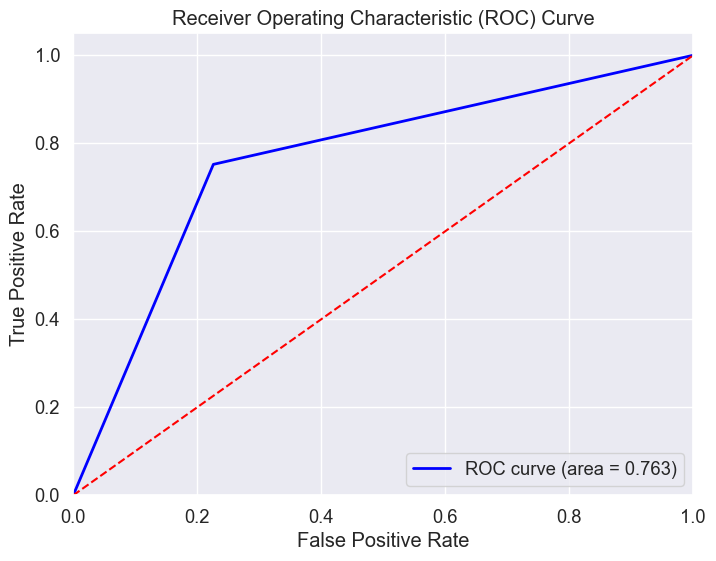

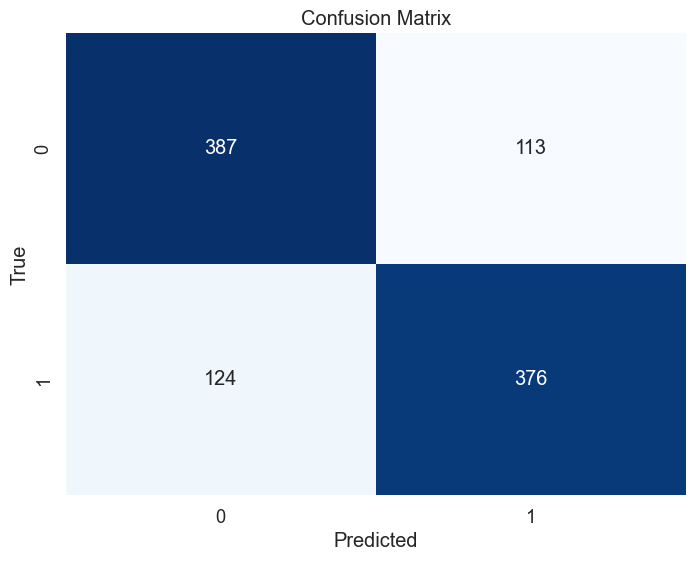

MLP - Cross-Validation AUC_score: 0.7630000000000001
MLP - Accuracy: 0.763
MLP - Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       500
           1       0.77      0.75      0.76       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000

MLP - Cross-Validation F1 Scores: [0.81884058 0.769977   0.76       0.73958333 0.749975   0.75913288
 0.709971   0.78896593 0.729973   0.79967949]
MLP - Cross-Validation Average F1 Score with variance: (0.7626098201256082, 0.0009829744549610532)


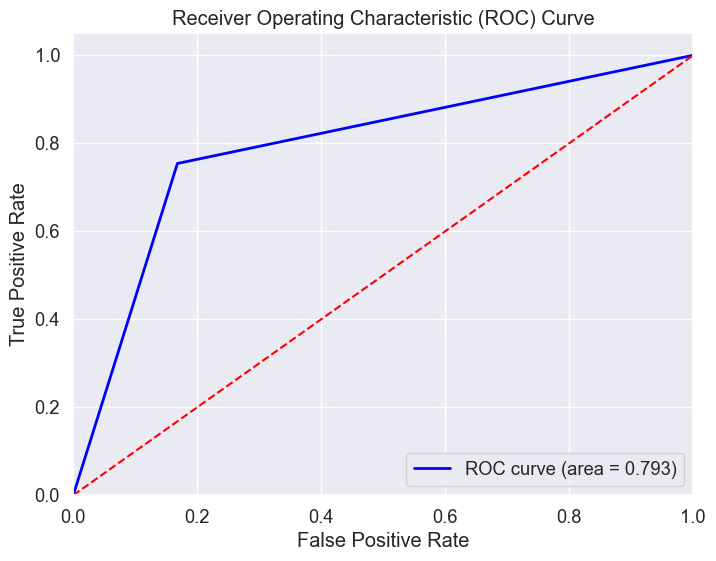

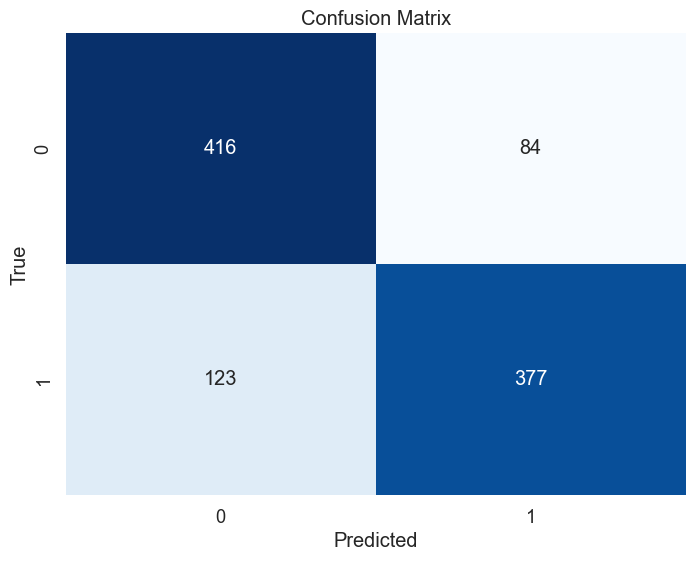

SVM - Cross-Validation AUC_score: 0.7929999999999999
SVM - Cross-Validation Accuracy: 0.793
SVM - Cross-Validation Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80       500
           1       0.82      0.75      0.78       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000

SVM - Cross-Validation F1 Scores: [0.74937343 0.849985   0.78742788 0.74       0.74876897 0.83993597
 0.81884058 0.79967949 0.78       0.80952381]
SVM - Cross-Validation Average F1 Score with variance: (0.7923535128145446, 0.0013300193724349056)


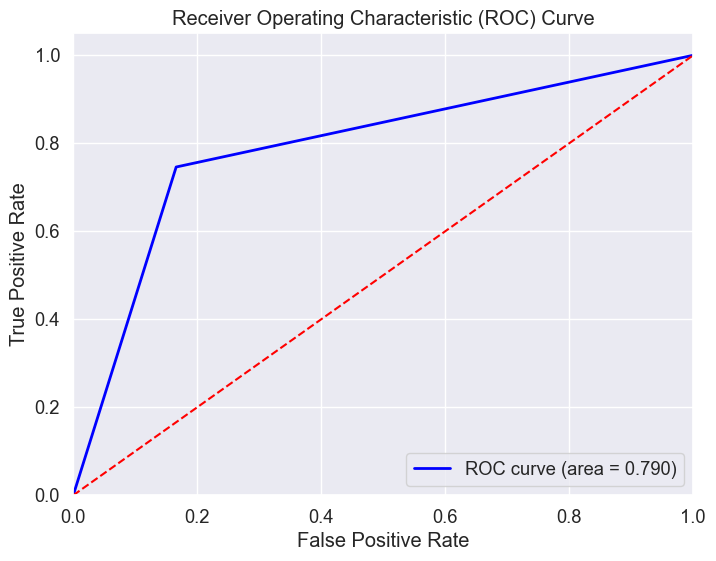

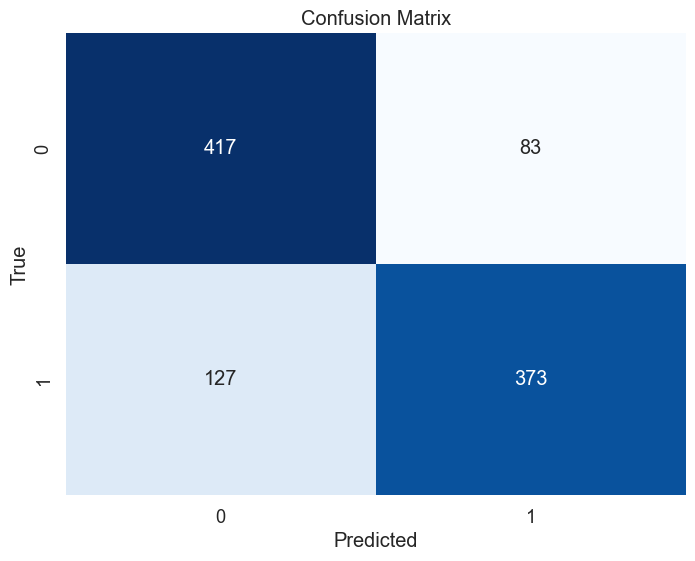

Logistic - Cross-Validation AUC_score: 0.79
Logistic - Cross-Validation Accuracy: 0.79
Logistic - Cross-Validation Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80       500
           1       0.82      0.75      0.78       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000

Logistic - Cross-Validation F1 Scores: [0.85909823 0.81971154 0.77920514 0.75913288 0.82984686 0.76979281
 0.76886745 0.79991997 0.75757576 0.74937343]
Logistic - Cross-Validation Average F1 Score with variance: (0.789252406934822, 0.0011964002619988129)


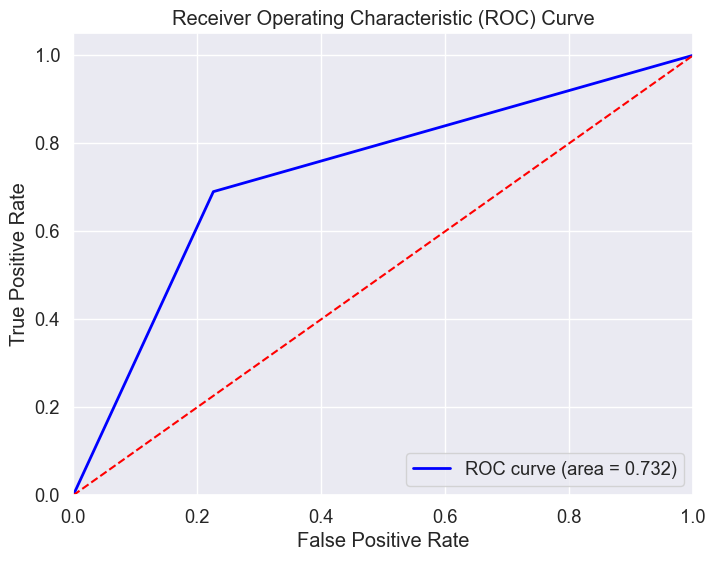

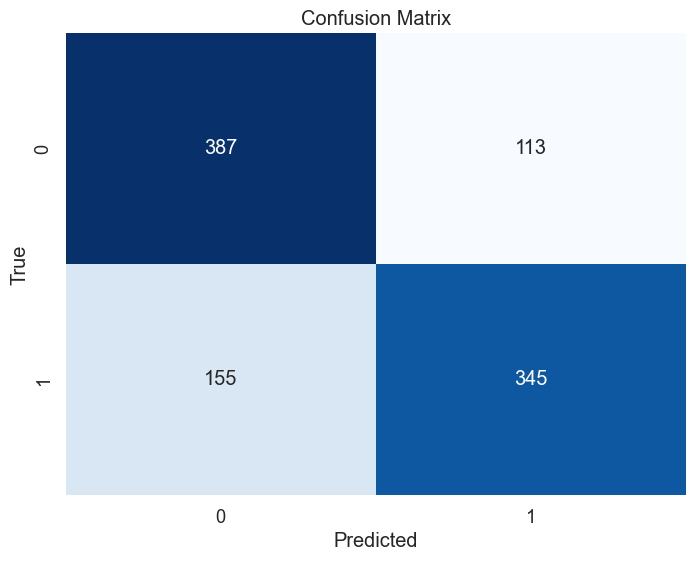

Decision Tree - Cross-Validation AUC_score: 0.732
Decision Tree - Cross-Validation Accuracy: 0.732
Decision Tree - Cross-Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.77      0.74       500
           1       0.75      0.69      0.72       500

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000

Decision Tree - Cross-Validation F1 Scores: [0.708572   0.75978381 0.73989596 0.73419594 0.74314422]
Decision Tree - Cross-Validation Average F1 Score with variance: (0.7371183852632726, 0.00027623669052000334)


C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\A

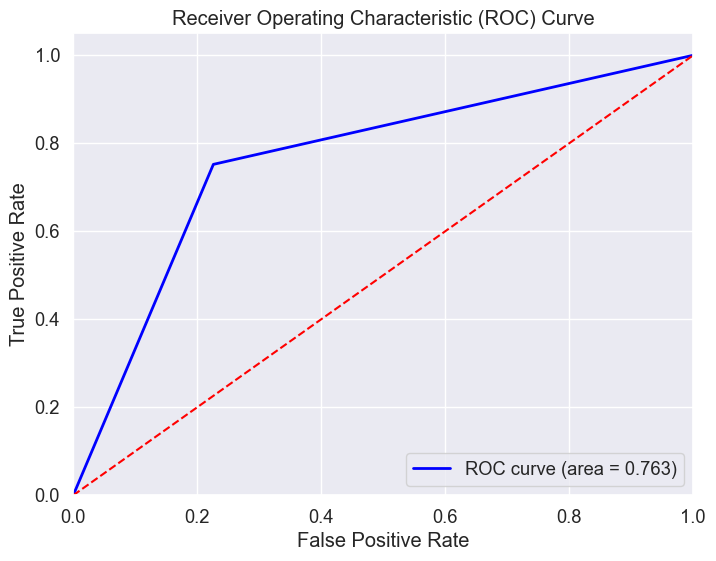

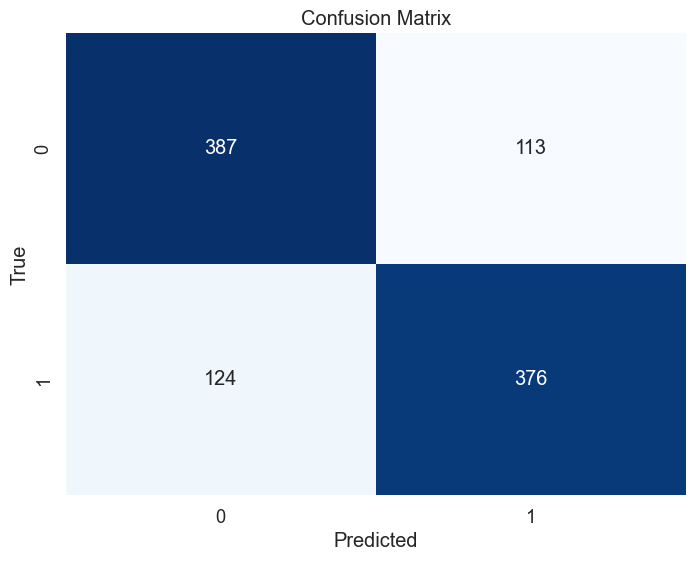

MLP - Cross-Validation AUC_score: 0.7630000000000001
MLP - Accuracy: 0.763
MLP - Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       500
           1       0.77      0.75      0.76       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000

MLP - Cross-Validation F1 Scores: [0.81884058 0.769977   0.76       0.73958333 0.749975   0.75913288
 0.709971   0.78896593 0.729973   0.79967949]
MLP - Cross-Validation Average F1 Score with variance: (0.7626098201256082, 0.0009829744549610532)


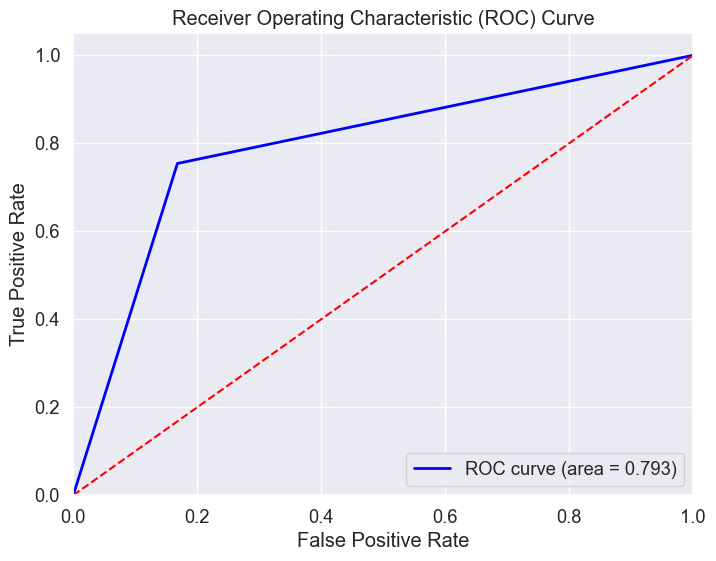

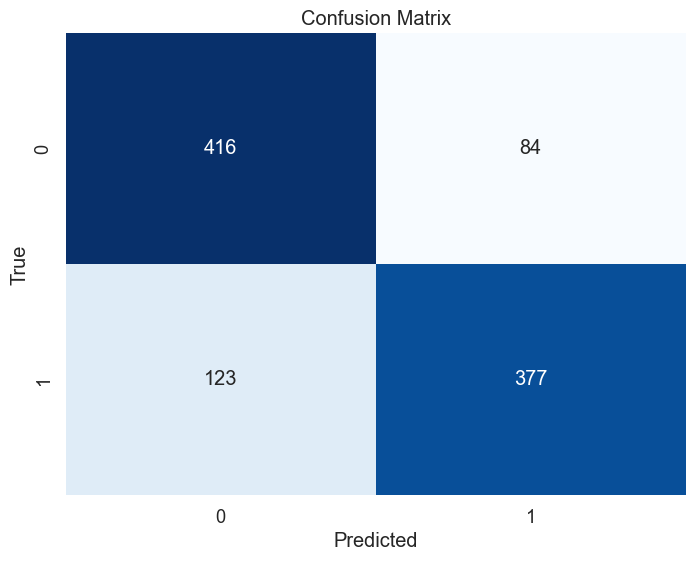

SVM - Cross-Validation AUC_score: 0.7929999999999999
SVM - Cross-Validation Accuracy: 0.793
SVM - Cross-Validation Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80       500
           1       0.82      0.75      0.78       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000

SVM - Cross-Validation F1 Scores: [0.74937343 0.849985   0.78742788 0.74       0.74876897 0.83993597
 0.81884058 0.79967949 0.78       0.80952381]
SVM - Cross-Validation Average F1 Score with variance: (0.7923535128145446, 0.0013300193724349056)


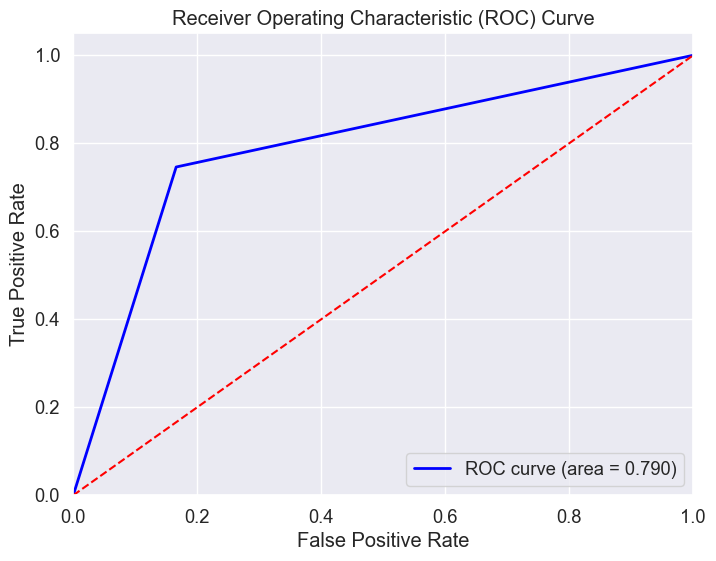

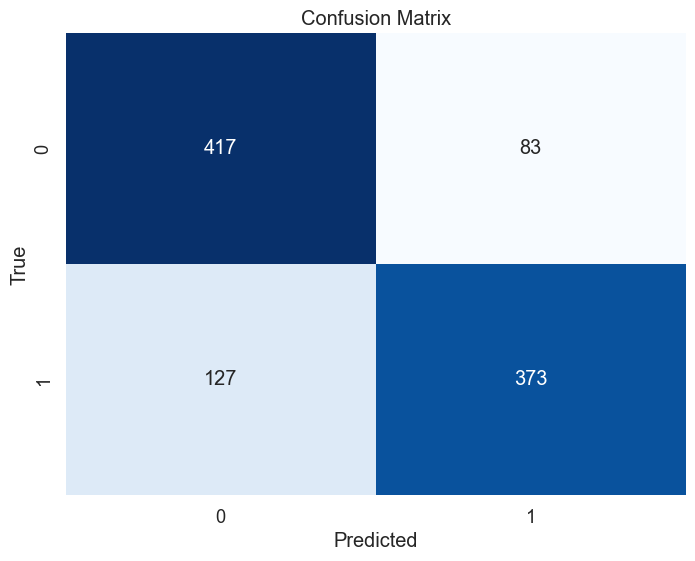

Logistic - Cross-Validation AUC_score: 0.79
Logistic - Cross-Validation Accuracy: 0.79
Logistic - Cross-Validation Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80       500
           1       0.82      0.75      0.78       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000

Logistic - Cross-Validation F1 Scores: [0.85909823 0.81971154 0.77920514 0.75913288 0.82984686 0.76979281
 0.76886745 0.79991997 0.75757576 0.74937343]
Logistic - Cross-Validation Average F1 Score with variance: (0.789252406934822, 0.0011964002619988129)


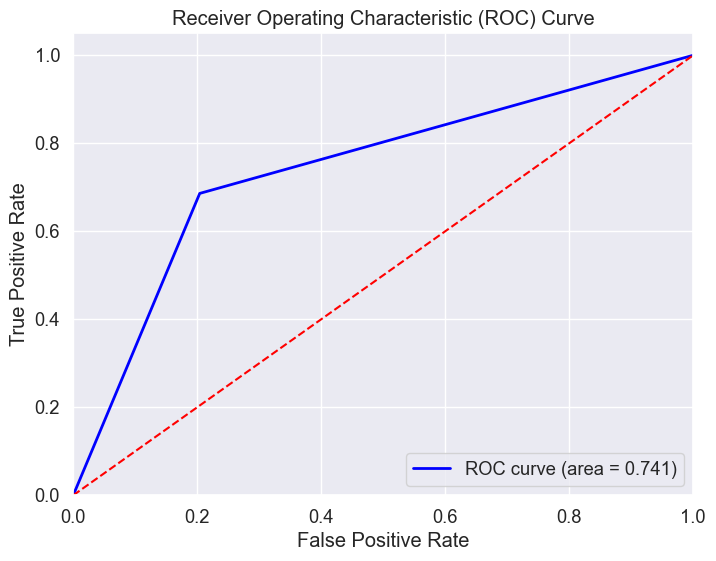

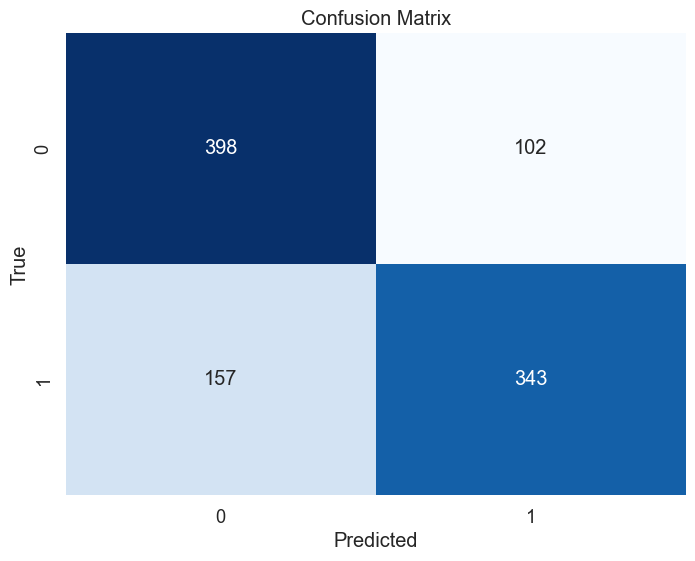

Decision Tree - Cross-Validation AUC_score: 0.741
Decision Tree - Cross-Validation Accuracy: 0.741
Decision Tree - Cross-Validation Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.80      0.75       500
           1       0.77      0.69      0.73       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000

Decision Tree - Cross-Validation F1 Scores: [0.73446229 0.72482802 0.74989996 0.75361408 0.68887997]
Decision Tree - Cross-Validation Average F1 Score with variance: (0.7303368621408416, 0.0005381168409324372)


C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nadon\A

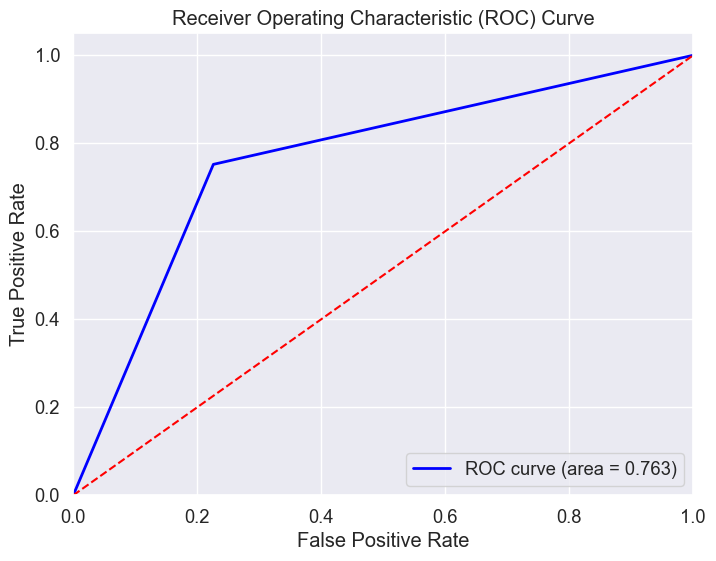

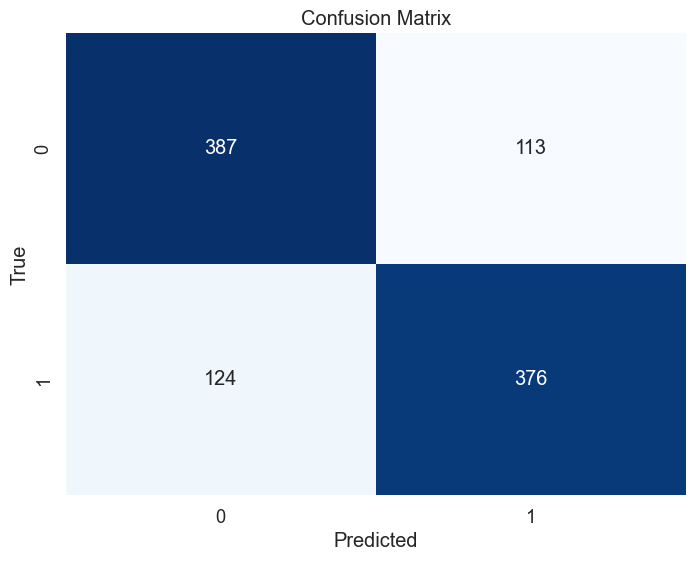

MLP - Cross-Validation AUC_score: 0.7630000000000001
MLP - Accuracy: 0.763
MLP - Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       500
           1       0.77      0.75      0.76       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000

MLP - Cross-Validation F1 Scores: [0.81884058 0.769977   0.76       0.73958333 0.749975   0.75913288
 0.709971   0.78896593 0.729973   0.79967949]
MLP - Cross-Validation Average F1 Score with variance: (0.7626098201256082, 0.0009829744549610532)


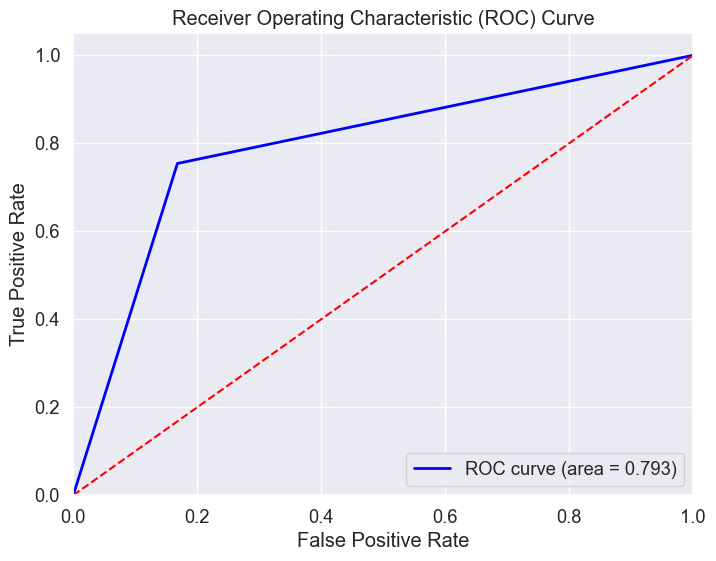

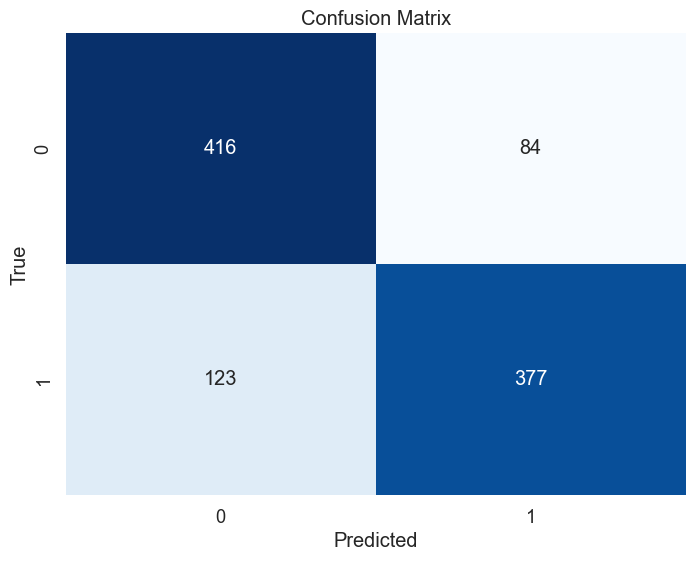

SVM - Cross-Validation AUC_score: 0.7929999999999999
SVM - Cross-Validation Accuracy: 0.793
SVM - Cross-Validation Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80       500
           1       0.82      0.75      0.78       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000

SVM - Cross-Validation F1 Scores: [0.74937343 0.849985   0.78742788 0.74       0.74876897 0.83993597
 0.81884058 0.79967949 0.78       0.80952381]
SVM - Cross-Validation Average F1 Score with variance: (0.7923535128145446, 0.0013300193724349056)


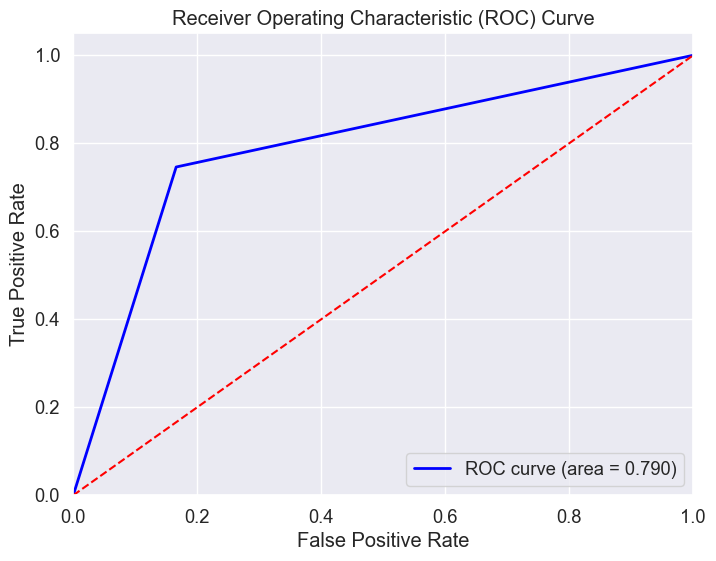

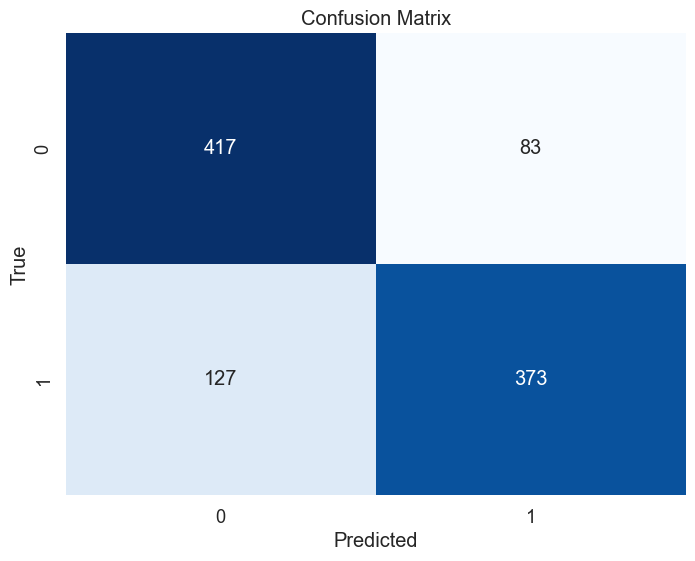

Logistic - Cross-Validation AUC_score: 0.79
Logistic - Cross-Validation Accuracy: 0.79
Logistic - Cross-Validation Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80       500
           1       0.82      0.75      0.78       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000

Logistic - Cross-Validation F1 Scores: [0.85909823 0.81971154 0.77920514 0.75913288 0.82984686 0.76979281
 0.76886745 0.79991997 0.75757576 0.74937343]
Logistic - Cross-Validation Average F1 Score with variance: (0.789252406934822, 0.0011964002619988129)


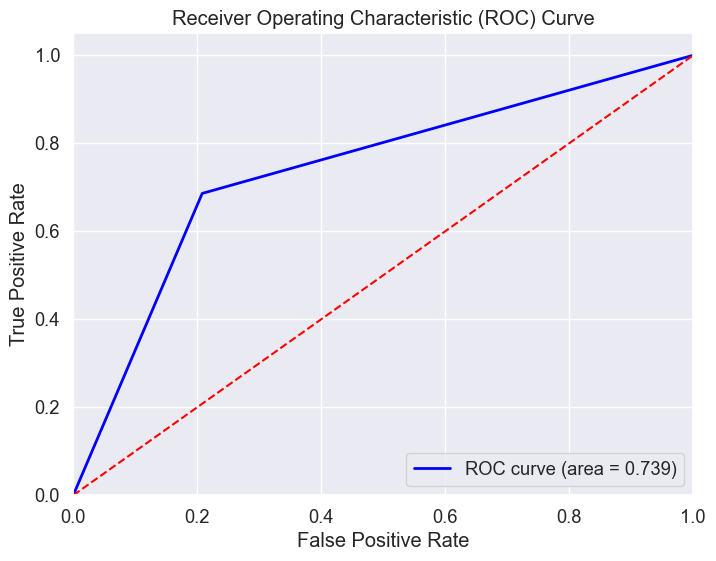

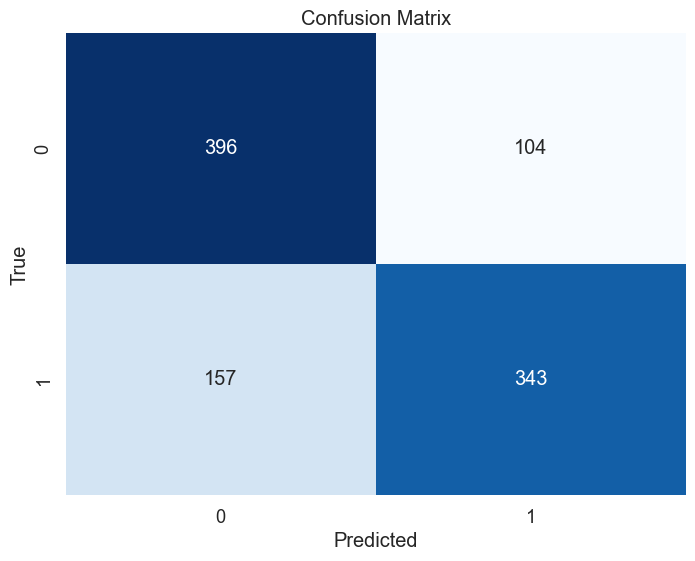

Decision Tree - Cross-Validation AUC_score: 0.739
Decision Tree - Cross-Validation Accuracy: 0.739
Decision Tree - Cross-Validation Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.79      0.75       500
           1       0.77      0.69      0.72       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000

Decision Tree - Cross-Validation F1 Scores: [0.71379077 0.75494486 0.75494486 0.75361408 0.71898836]
Decision Tree - Cross-Validation Average F1 Score with variance: (0.739256585691811, 0.00035153814149218996)


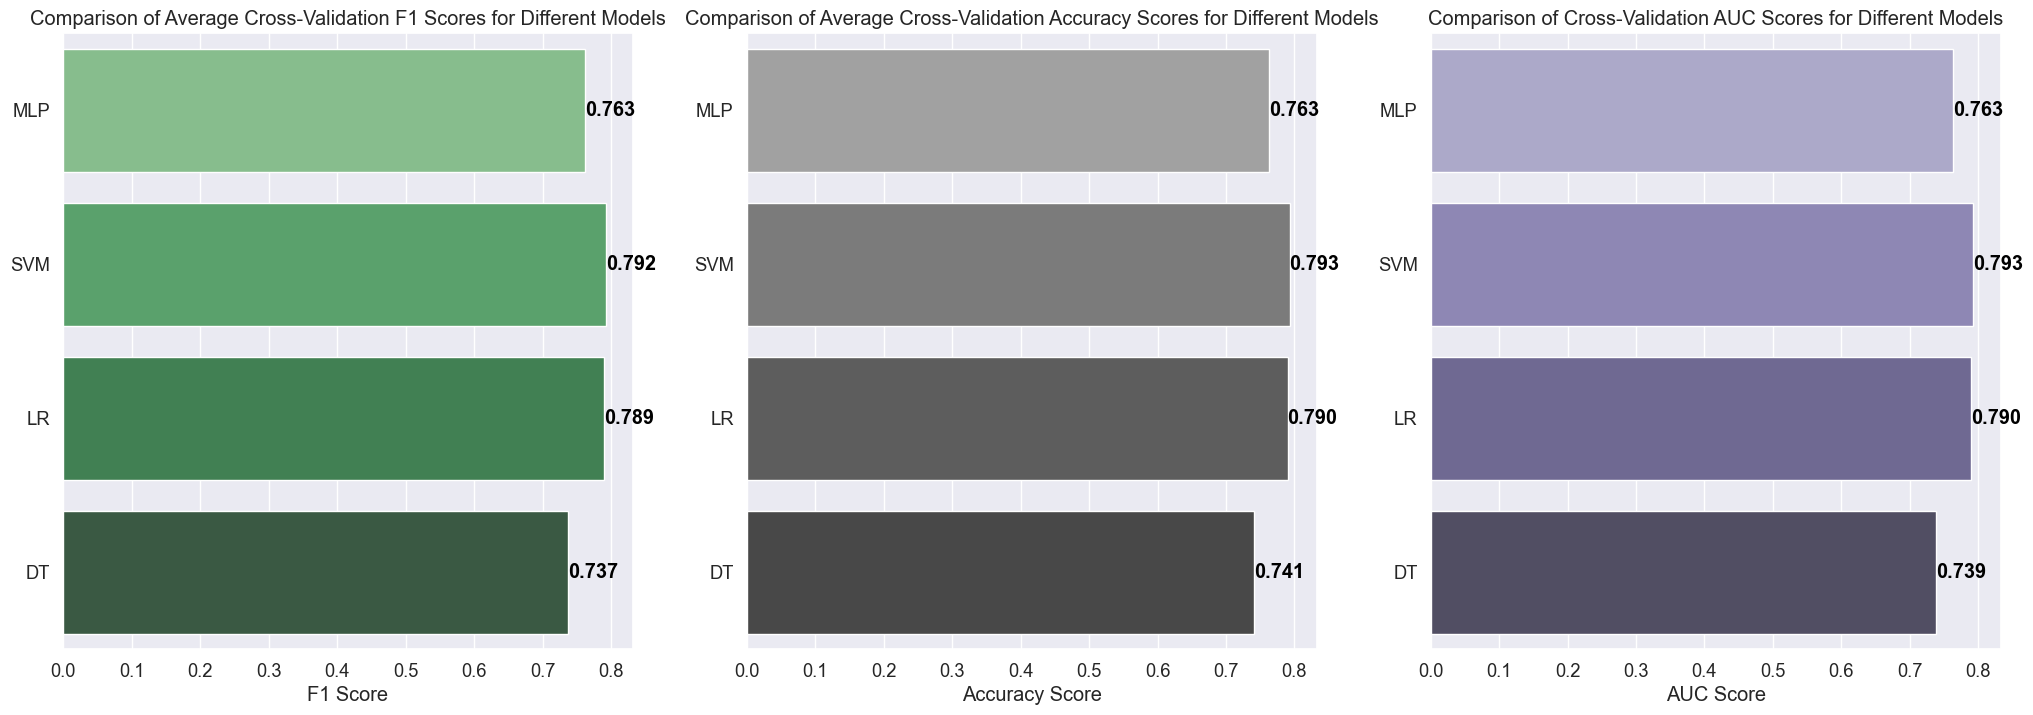

In [25]:
auc_scores = []
a_scores = []
f1_scores = []

functions = [multiclass_cv_mlp, multiclass_cv_svm, multiclass_cv_logistic_regression, multiclass_cv_decision_tree]
labels = ["MLP", "SVM", "LR", "DT"]

for func in functions:
    f1 = func(tv_reviews, y1)[0].mean()
    f1_scores.append(f1)
for func in functions:
    a = func(tv_reviews, y1)[1]
    a_scores.append(a)
for func in functions:
    au = func(tv_reviews, y1)[2]
    auc_scores.append(au)

# Combine all three plots into one figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(25, 8))

# F1 Score subplot
sns.barplot(ax=axes[0], x=f1_scores, y=labels, palette="Greens_d")
axes[0].set_xlabel('F1 Score')
axes[0].set_title('Comparison of Average Cross-Validation F1 Scores for Different Models')
for i, v in enumerate(f1_scores):
    axes[0].text(v, i, f'{v:.3f}', va='center', color='black', fontweight='bold')

# Accuracy Score subplot
sns.barplot(ax=axes[1], x=a_scores, y=labels, palette="Greys_d")
axes[1].set_xlabel('Accuracy Score')
axes[1].set_title('Comparison of Average Cross-Validation Accuracy Scores for Different Models')
for i, v in enumerate(a_scores):
    axes[1].text(v, i, f'{v:.3f}', va='center', color='black', fontweight='bold')

# AUC Score subplot
sns.barplot(ax=axes[2], x=auc_scores, y=labels, palette="Purples_d")
axes[2].set_xlabel('AUC Score')
axes[2].set_title('Comparison of Cross-Validation AUC Scores for Different Models')
for i, v in enumerate(auc_scores):
    axes[2].text(v, i, f'{v:.3f}', va='center', color='black', fontweight='bold')

#plt.tight_layout()
plt.show()